In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn import metrics
%matplotlib inline 

## Считывание датасета и просмотр статистик с визуализациями

In [2]:
df = pd.read_csv("new-york-city-airbnb-open-data.zip", compression="zip")

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Рассчитаем расстояние квартир до центра города

In [4]:
def distance(x):
    center = (40.728333, -73.994167)
    return geodesic(center, (x.latitude, x.longitude)).km
df['center_distance'] = df.apply(distance, axis=1)

Удаляем лишние столбцы вместе с координатами квартир, т.к. они уже не нужны

In [5]:
df.drop(columns=['latitude', 'longitude', 'id', 'name', 'host_id', 'host_name', 'last_review'], inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 10 columns):
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64
center_distance                   48895 non-null float64
dtypes: float64(2), int64(5), object(3)
memory usage: 3.7+ MB


In [7]:
df.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,center_distance
count,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000,48895.000000
mean,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327,6.710392
std,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289,4.408973
min,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.018280
25%,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000,3.548283
50%,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000,6.208778
75%,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000,8.777253
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,32.860753


In [8]:
df.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
center_distance                       0
dtype: int64

В **"reviews_per_month"** много пропусков, заменим их медианой, а так же удалим строки с нулевыми ценами, поскольку они не несут никакой смысловой нагрузки (цена не может быть равна нулю)

In [9]:
df.fillna(df.median(), inplace = True)
df = df[df['price'] > 0]

Посмотрим на распределение целевой переменной - **"price"**

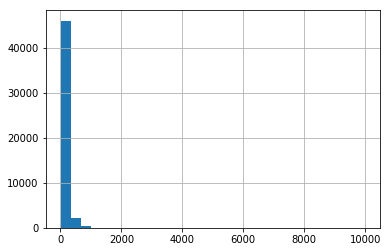

In [10]:
df.price.hist(bins=30)
plt.show()

Целевая переменная имеет тяжелый правый хвост, прологорифмируем её и получим более нормальное распределение

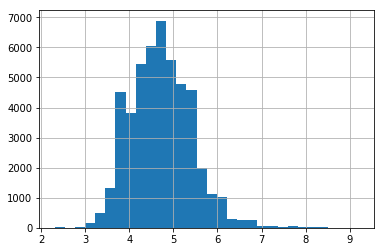

In [11]:
df['price'] = np.log(df['price'])
df.price.hist(bins=30)
plt.show()

Теперь посмотрим на распределение остальных числовых переменных

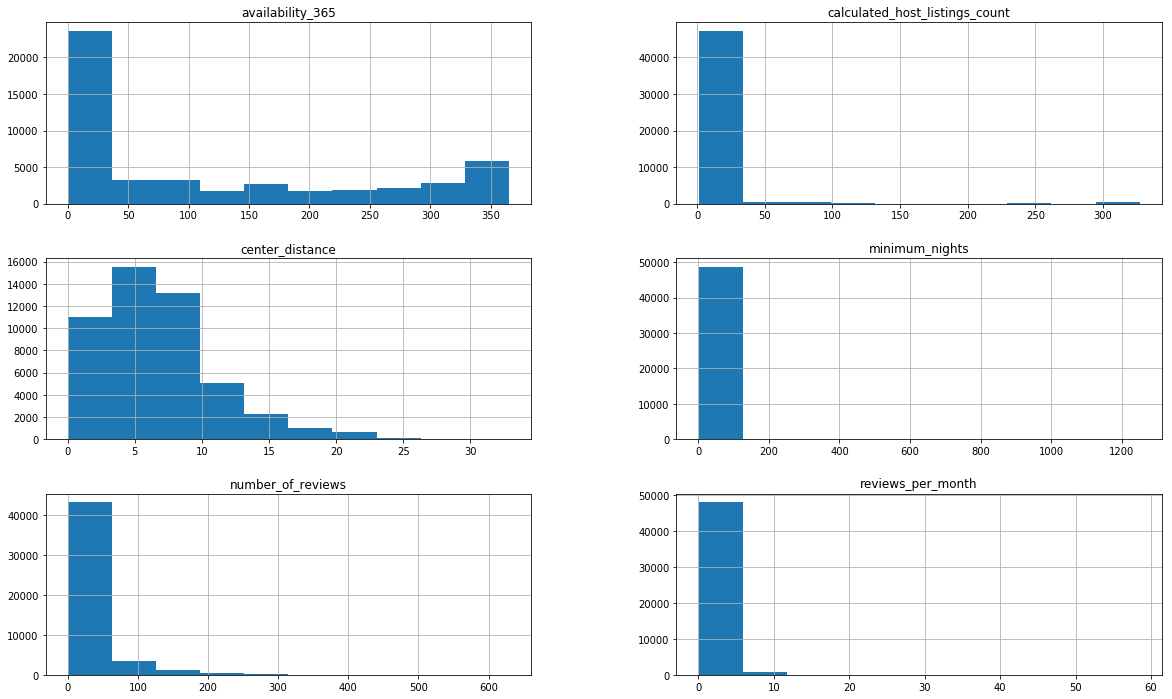

In [12]:
df.drop('price',axis=1).hist(figsize=(20, 12))
plt.show()

Рисуем тепловую карту для корреляций

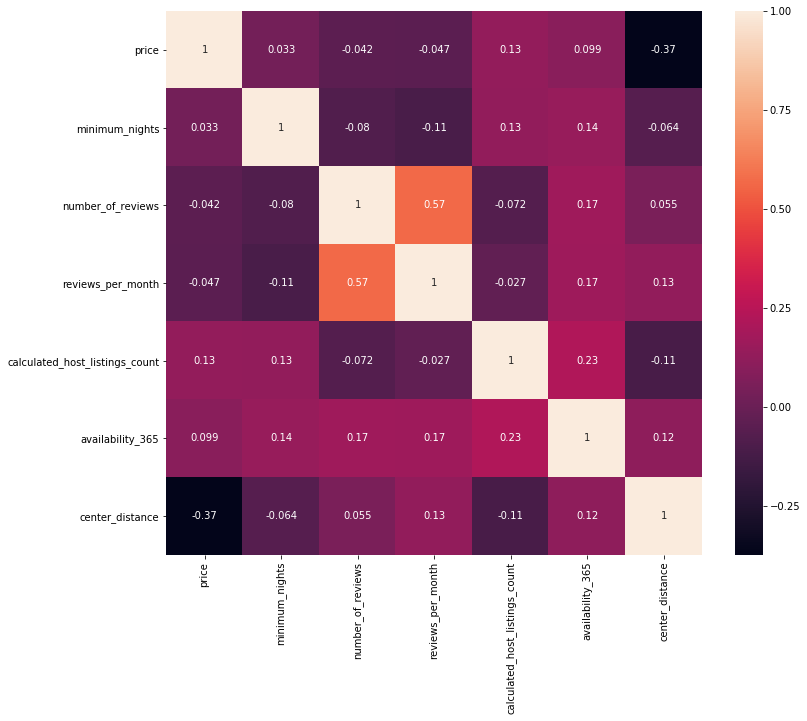

In [13]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()

Посмотрим на облака рассеивания

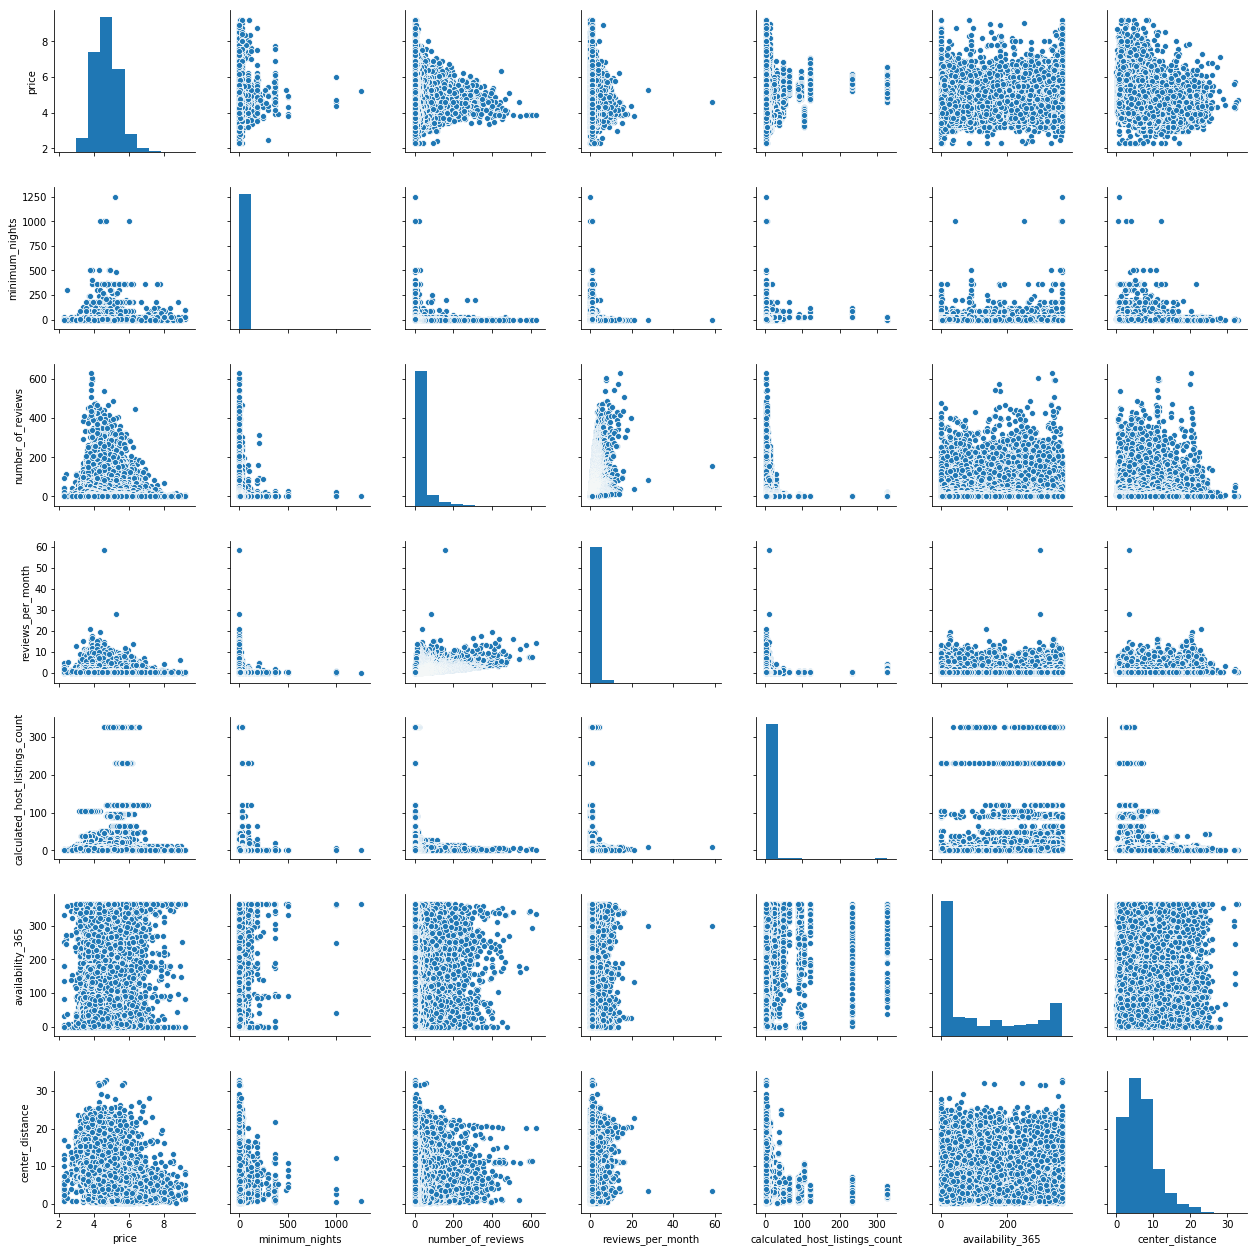

In [14]:
sns.pairplot(df)
plt.show()

У двух переменных наблюдаем выбросы - **"reviews_per_month"**, **"minimum_nights"**, удалим эти объекты для более корректной работы линейных алгоритмов

In [15]:
q_rpm = df['reviews_per_month'].quantile(0.9999)
q_rpm, df[df['reviews_per_month'] >= q_rpm].shape

(16.922816999993955, (5, 10))

In [16]:
q_mn = df['minimum_nights'].quantile(0.9999)
q_mn, df[df['minimum_nights'] >= q_mn].shape

(555.7382999970141, (5, 10))

In [17]:
df = df[df['reviews_per_month'] < q_rpm]
df = df[df['minimum_nights'] < q_mn]
df.reset_index(inplace = True, drop=True)

Еще раз посмотрим на итоговые получившиеся статистики и облака рассеивания, и увидим, что количество объектов снизилилось крайне незначительно, но при этом избавились от нулевых цен и выбросов

In [18]:
df.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,center_distance
count,48874.000000,48874.000000,48874.000000,48874.000000,48874.000000,48874.000000,48874.000000
mean,4.727040,6.923865,23.255330,1.236072,7.145374,112.758256,6.709762
std,0.698239,17.567987,44.494217,1.486918,32.959485,131.617578,4.407847
min,2.302585,1.000000,0.000000,0.010000,1.000000,0.000000,0.018280
25%,4.234107,1.000000,1.000000,0.280000,1.000000,0.000000,3.548536
50%,4.663439,3.000000,5.000000,0.720000,1.000000,45.000000,6.208776
75%,5.164786,5.000000,24.000000,1.580000,2.000000,227.000000,8.777293
max,9.210340,500.000000,629.000000,16.810000,327.000000,365.000000,32.860753


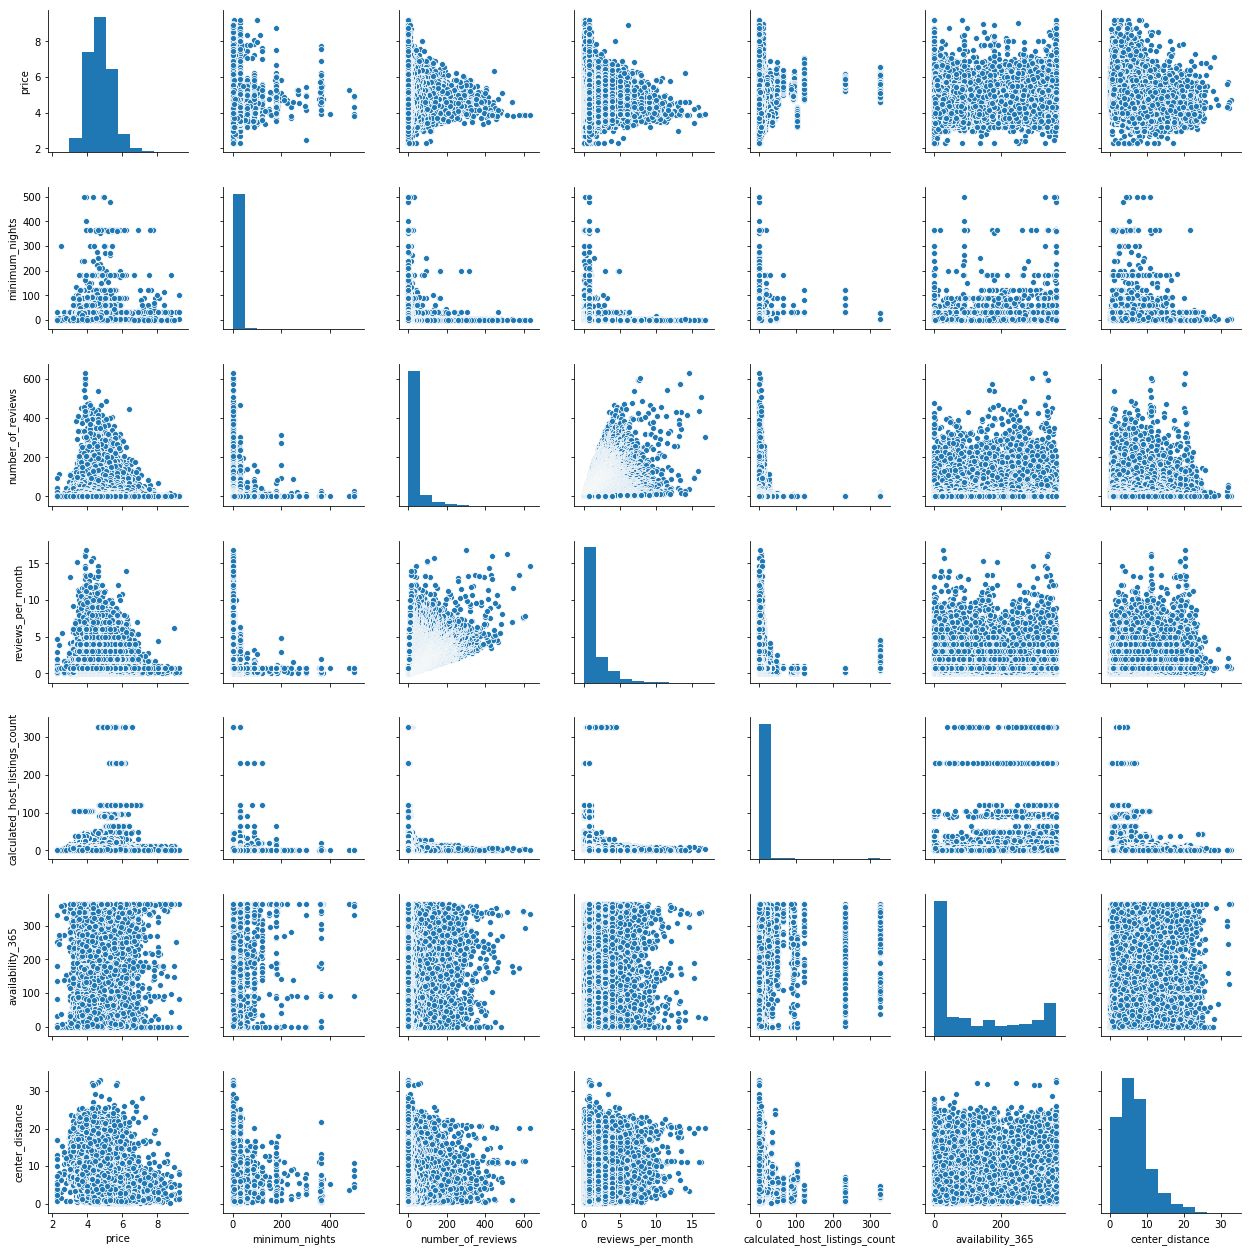

In [19]:
sns.pairplot(df)
plt.show()

Теперь взглянем на категориальные признаки

In [20]:
df.describe(include=['object'])

,neighbourhood_group,neighbourhood,room_type
count,48874,48874,48874
unique,5,221,3
top,Manhattan,Williamsburg,Entire home/apt
freq,21654,3918,25404


Перекодируем категориальные признаки в бинарные

In [21]:
enc = OneHotEncoder(drop='first', sparse=False)
arr = enc.fit_transform(df[['neighbourhood_group', 'room_type', 'neighbourhood']])
arr = pd.DataFrame(arr, columns = enc.get_feature_names(['neighbourhood_group', 'room_type', 'neighbourhood']))
df = pd.concat([df.drop(['neighbourhood', 'neighbourhood_group', 'room_type'] ,axis=1), arr], axis=1)

Разделим датафрейм на тренировочную и тестовую выборки 70/30

In [22]:
df_train, df_test = train_test_split(df, test_size = 0.3)

Нормализуем числовые признаки

In [23]:
scaler = StandardScaler()
scaler.fit(df_train[['minimum_nights', 'number_of_reviews', 'availability_365', 'calculated_host_listings_count','reviews_per_month', 'center_distance']]) 

df_train_scale = scaler.transform(df_train[['minimum_nights', 'number_of_reviews', 'availability_365', 'calculated_host_listings_count','reviews_per_month', 'center_distance']])

df_test_scale = scaler.transform(df_test[['minimum_nights', 'number_of_reviews', 'availability_365', 'calculated_host_listings_count','reviews_per_month', 'center_distance']])

df_train[['minimum_nights', 'number_of_reviews', 'availability_365', 'calculated_host_listings_count','reviews_per_month', 'center_distance']] = df_train_scale
df_test[['minimum_nights', 'number_of_reviews', 'availability_365', 'calculated_host_listings_count','reviews_per_month', 'center_distance']] = df_test_scale

C:\Users\rusak\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\rusak\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\rusak\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

In [24]:
df_train.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,center_distance,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside
39422,4.077537,-0.108256,-0.407788,0.126646,-0.153607,-0.854669,-0.936306,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41243,5.192957,-0.222785,0.060723,2.809244,-0.184129,-0.451388,-0.990225,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21824,3.828641,-0.050991,-0.497029,-0.800919,-0.184129,-0.854669,0.251647,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36604,4.828314,-0.337315,-0.273928,0.013203,-0.184129,-0.854669,-1.395323,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29150,4.330733,-0.280050,0.663095,1.274424,-0.153607,-0.276379,-0.234159,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Выделим целевую переменную отдельно

In [25]:
y_train = df_train.price 
y_test = df_test.price 

X_train = df_train.drop('price', axis=1)
X_test = df_test.drop('price', axis=1)

In [26]:
# функция для расчета метрик
def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred)))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred))))
    print('R2:',  metrics.r2_score(np.exp(y_test), np.exp(y_pred)))
    print ('MAPE:', np.mean(np.abs((np.exp(y_test) - np.exp(y_pred)) / np.exp(y_test))) * 100)

Создадим линейные регрессоры и обучим их

In [27]:
model_RidgeCV = RidgeCV()
model_RidgeCV.fit(X_train, y_train)

model_lassoCV = LassoCV()
model_lassoCV.fit(X_train, y_train)

model_ElasticNetCV = ElasticNetCV()
model_ElasticNetCV.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

Посмотрим основные метрики

In [28]:
# lassoCV
print_metrics(y_test, model_lassoCV.predict(X_test))

MAE: 63.02502912113341
RMSE: 265.60667807862603
R2: 0.07787672726102723
MAPE: 35.3026413462768


In [29]:
# RidgeCV
print_metrics(y_test, model_RidgeCV.predict(X_test))

MAE: 63.04202284315682
RMSE: 265.4394375718192
R2: 0.07903760027109974
MAPE: 35.21288384376861


In [30]:
# ElasticNetCv
print_metrics(y_test, model_ElasticNetCV.predict(X_test))

MAE: 63.02093218888308
RMSE: 265.6407810830642
R2: 0.07763991700349893
MAPE: 35.31490976583646


Качество практически одинаковое между регрессорами.
Теперь посмотрим на их коэффициенты

In [31]:
model_lassoCV.coef_

array([-4.64201396e-02, -3.27988940e-02,  3.55862176e-04, -1.40320395e-02,
        1.06015841e-01, -1.29100307e-01,  1.36086383e-02,  2.37415829e-01,
        0.00000000e+00, -0.00000000e+00, -7.18742820e-01, -1.07192963e+00,
       -0.00000000e+00, -0.00000000e+00,  4.26417754e-01, -3.75827666e-02,
       -0.00000000e+00,  7.30993513e-02, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.42793764e-01,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  8.40069674e-02, -2.21003238e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        1.50080199e-01, -2.02134303e-02, -0.00000000e+00, -1.70768222e-01,
        0.00000000e+00, -5.38520133e-03,  1.08140601e-01, -0.00000000e+00,
        0.00000000e+00,  1.03401015e-01, -7.71304839e-02,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.33649548e-02,  

In [32]:
model_RidgeCV.coef_

array([-4.71609978e-02, -3.35929574e-02,  2.82675481e-03, -1.71237614e-02,
        1.07163238e-01, -2.18879883e-01, -1.99356168e-01, -3.73427387e-02,
        3.88155294e-02,  8.92593776e-02, -7.09610667e-01, -1.06475105e+00,
       -6.19186797e-02, -2.29502093e-01,  5.97426521e-01, -3.35804822e-01,
       -6.16555109e-02,  1.93816547e-01,  1.06864940e-02,  3.41459835e-01,
        2.83226103e-01,  0.00000000e+00,  2.24232671e-01,  2.67224363e-01,
       -1.98713658e-01,  5.12315718e-01,  3.88318840e-01, -8.92687698e-02,
       -1.06038214e-01, -5.57991586e-02,  6.78502636e-02, -2.99702779e-01,
        1.09712794e+00, -6.01193395e-02,  2.92744941e-01, -2.92152083e-01,
        1.25291409e-01, -2.01424633e-01, -2.12099557e-01, -2.15815433e-01,
        2.53660003e-01, -1.73539335e-02,  8.74490742e-02, -3.68409465e-01,
        9.36492795e-02,  3.47648373e-02, -2.01811624e-01,  4.42993530e-01,
       -1.19248975e-01, -1.65364059e-01, -5.14793271e-02, -1.06390252e-01,
       -4.25066021e-02,  

In [33]:
model_ElasticNetCV.coef_

array([-4.63479405e-02, -3.26427737e-02,  2.33582980e-04, -1.36697321e-02,
        1.05851468e-01, -1.28717682e-01,  1.36201474e-02,  2.46505063e-01,
       -0.00000000e+00, -0.00000000e+00, -7.18320827e-01, -1.06114214e+00,
       -0.00000000e+00, -0.00000000e+00,  3.69351359e-01, -3.48846016e-02,
       -0.00000000e+00,  5.61224402e-02, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.39982052e-01,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  8.11135392e-02, -1.99958928e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        1.41409195e-01, -1.50308935e-02, -0.00000000e+00, -1.67775273e-01,
        0.00000000e+00, -2.88056049e-03,  1.05310379e-01, -0.00000000e+00,
        0.00000000e+00,  9.60321095e-02, -8.05629997e-02,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.55360162e-02,  

Видим, что у Lasso и Elastic регрессий многие коэффициенты при признаках были занулены, в отличии от Ridge регрессии.
Теперь посмотрим на 10 наиболее значимых признаков у каждой регрессии.
5 наиболее положительно значимых и 5 наиболее отрицательно значимых.

In [34]:
# функция построения гистограммы значимых признаков
def feature(model):  
    featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                      "importance": model.coef_})

    featureImportance.set_index('feature', inplace=True)
    featureImportance.sort_values(["importance"], ascending=False, inplace=True)
    featureImportance = pd.concat([featureImportance[:5], featureImportance[-5:]])
    featureImportance["importance"].plot('bar', figsize=(8, 4))
    print(featureImportance)

                               importance
feature                                  
neighbourhood_Tribeca            0.468392
neighbourhood_Arverne            0.426418
neighbourhood_Midtown            0.272372
neighbourhood_group_Manhattan    0.237416
neighbourhood_Rockaway Beach     0.189470
neighbourhood_Maspeth           -0.191901
neighbourhood_Borough Park      -0.221003
neighbourhood_Ridgewood         -0.237714
room_type_Private room          -0.718743
room_type_Shared room           -1.071930


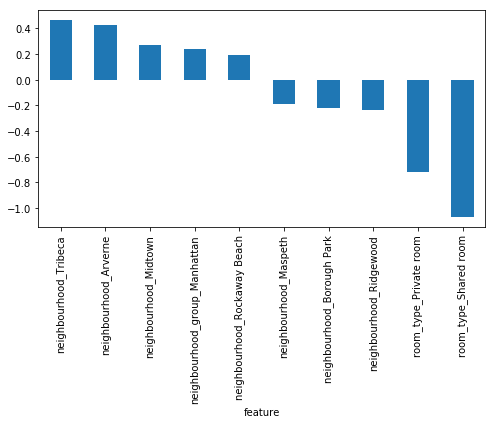

In [35]:
feature(model_lassoCV)

                              importance
feature                                 
neighbourhood_Prince's Bay      1.236792
neighbourhood_Breezy Point      1.097128
neighbourhood_Riverdale         0.906260
neighbourhood_Fort Wadsworth    0.789499
neighbourhood_Tottenville       0.784480
neighbourhood_Ridgewood        -0.540471
neighbourhood_Corona           -0.559545
neighbourhood_Maspeth          -0.572140
room_type_Private room         -0.709611
room_type_Shared room          -1.064751


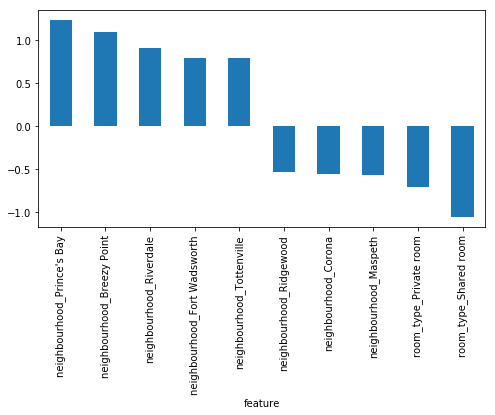

In [36]:
feature(model_RidgeCV)

                                importance
feature                                   
neighbourhood_Tribeca             0.433014
neighbourhood_Arverne             0.369351
neighbourhood_Midtown             0.263816
neighbourhood_group_Manhattan     0.246505
neighbourhood_Theater District    0.171906
neighbourhood_Sunnyside          -0.176012
neighbourhood_Borough Park       -0.199959
neighbourhood_Ridgewood          -0.229194
room_type_Private room           -0.718321
room_type_Shared room            -1.061142


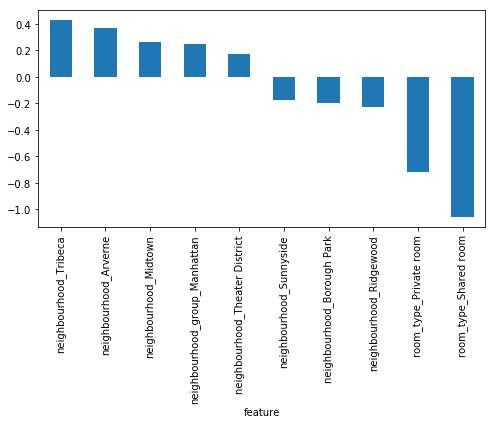

In [37]:
feature(model_ElasticNetCV)

Получилось, что у Lasso и Elastic почти совпадают признаки. У Ridge признаки увеличивающие прайс квартир отличается.
Но признаки, которые отрицательно влияют на стоимость квартиры у всех регрессий совпали - Shared room и Private room.
Значит можно сказать с высокой точностью, что эти параметры точно уменьшают стоимость квартиры.